In [1]:
from tensorflow.keras import layers,models
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
import data_construction as dc
from sklearn.decomposition import PCA

In [10]:
clean_data = 'cleaned_full_data.csv'

# import data
df = pd.read_csv(clean_data, index_col=0)

# interpolate and join
test = dc.det_interp(df.iloc[:,1])
econ_interp = df.iloc[:,:-1].apply(dc.det_interp, axis=0)
df = pd.concat([econ_interp, df.iloc[:,-1]], axis=1, join="outer")

# perform time lags
df['SVENY10_1'] = df['SVENY10'].shift(1)
df['SVENY10_60'] = df['SVENY10'].shift(60)
df_lag_1 = df.iloc[:,:-1].dropna().drop(['SVENY10'], axis=1)
df_lag_60 = df.drop(['SVENY10_1', 
    'SVENY10'], axis=1).dropna()
df = df.iloc[:,:-2]

In [44]:
df_pca = df_lag_1.iloc[:, :-1]
pca = PCA(n_components=1)
pca.fit(df_pca)
df_pca = pd.DataFrame(pca.transform(df_pca), index=df_lag_1.index)
df_pca['SVENY10_1'] =  df_lag_1['SVENY10_1']

In [45]:
def identity_block(input_tensor,units):
	"""The identity block is the block that has no conv layer at shortcut.
	# Arguments
		input_tensor: input tensor
		units:output shape
	# Returns
		Output tensor for the block.
	"""
	x = layers.Dense(units)(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation('relu')(x)

	x = layers.Dense(units)(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation('relu')(x)

	x = layers.Dense(units)(x)
	x = layers.BatchNormalization()(x)

	x = layers.add([x, input_tensor])
	x = layers.Activation('relu')(x)

	return x

def dens_block(input_tensor,units):
	"""A block that has a dense layer at shortcut.
	# Arguments
		input_tensor: input tensor
		unit: output tensor shape
	# Returns
		Output tensor for the block.
	"""
	x = layers.Dense(units)(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation('relu')(x)

	x = layers.Dense(units)(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation('relu')(x)

	x = layers.Dense(units)(x)
	x = layers.BatchNormalization()(x)

	shortcut = layers.Dense(units)(input_tensor)
	shortcut = layers.BatchNormalization()(shortcut)

	x = layers.add([x, shortcut])
	x = layers.Activation('relu')(x)
	return x


def ResNet50Regression():
	"""Instantiates the ResNet50 architecture.
	# Arguments        
		input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
			to use as input for the model.        
	# Returns
		A Keras model instance.
	"""
	Res_input = layers.Input(shape=(1,))

	width = 16

	x = dens_block(Res_input,width)
	x = identity_block(x,width)
	x = identity_block(x,width)

	x = dens_block(x,width)
	x = identity_block(x,width)
	x = identity_block(x,width)
	
	x = dens_block(x,width)
	x = identity_block(x,width)
	x = identity_block(x,width)

	x = layers.BatchNormalization()(x)
	x = layers.Dense(1, activation='linear')(x)
	model = models.Model(inputs=Res_input, outputs=x)

	return model

In [46]:
dataset = np.array(df_pca)

x = dataset[:,0:1]
y = dataset[:,1]
y = y.reshape(-1,1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(x)
xscale = scaler_x.transform(x)
scaler_y.fit(y)
yscale = scaler_y.transform(y)
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale,test_size=0.10)

In [47]:
model = ResNet50Regression()
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model.fit(X_train, y_train, epochs=50, verbose=2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=2, mode='auto')], validation_split=0.1)


Epoch 1/50
178/178 - 10s - loss: 0.3029 - mse: 0.3029 - val_loss: 0.0666 - val_mse: 0.0666
Epoch 2/50
178/178 - 1s - loss: 0.0761 - mse: 0.0761 - val_loss: 0.0580 - val_mse: 0.0580
Epoch 3/50
178/178 - 1s - loss: 0.0462 - mse: 0.0462 - val_loss: 0.0579 - val_mse: 0.0579
Epoch 4/50
178/178 - 1s - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 5/50
178/178 - 1s - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 6/50
178/178 - 1s - loss: 0.0255 - mse: 0.0255 - val_loss: 0.0097 - val_mse: 0.0097
Epoch 7/50
178/178 - 1s - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 8/50
178/178 - 1s - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 9/50
178/178 - 1s - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0072 - val_mse: 0.0072
Epoch 10/50
178/178 - 1s - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 11/50
178/178 - 1s - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 1

The time cost: 
0:00:48.793120
The test loss: 
0.006508676667024298


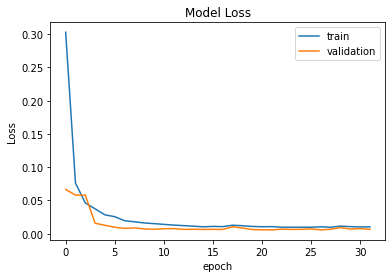

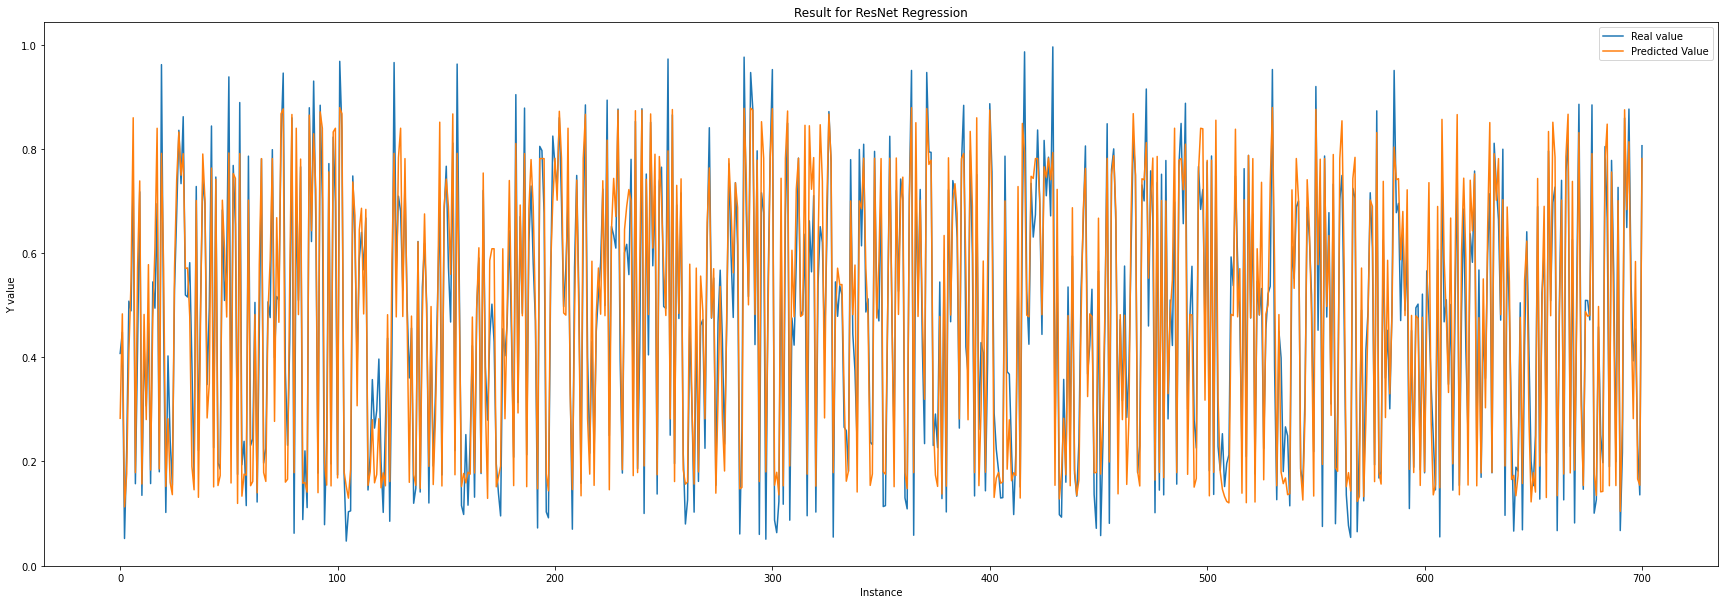

In [48]:
yhat = model.predict(X_test)

print('The test loss: ')
print(mean_squared_error(yhat,y_test)) 

# "Loss"
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

# plt.figure(2)
plt.figure(figsize=(30,10))
plt.plot(y_test) 
plt.plot(yhat)
plt.title('Result for ResNet Regression')
plt.ylabel('SVENY10')
plt.xlabel('Data points')
plt.legend(['Real value', 'Predicted Value'], loc='upper right')
plt.show()


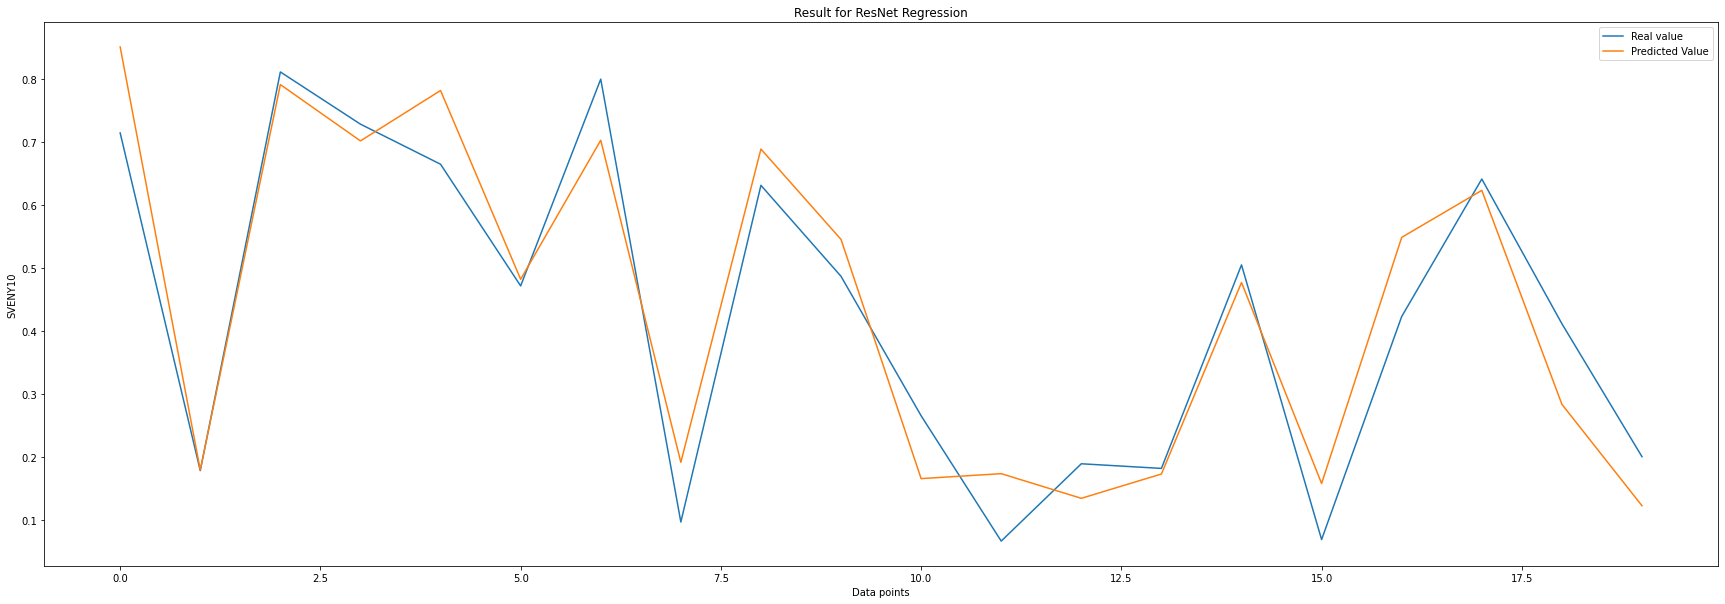

In [51]:
plt.figure(figsize=(30,10))
plt.plot(y_test[630:650]) 
plt.plot(yhat[630:650])
plt.title('Result for ResNet Regression')
plt.ylabel('SVENY10')
plt.xlabel('Data points')
plt.legend(['Real value', 'Predicted Value'], loc='upper right')